<br>

# Part 3 : [Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier # 신경망
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

<br>

### 1. Load and check data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test["PassengerId"]

<br>

### 1.1 outlier detection

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
#         print(IQR)
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# 이상치 삭제
train = train.drop(Outliers_to_drop, axis =0).reset_index(drop=True)

In [6]:
# joining train and test set

train_len = len(train)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

In [7]:
dataset = dataset.fillna(np.nan) # numpy의 nan 값으로 na 대체

dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<br>

### 2. Feature analysis

#### 2.1 Numerical values

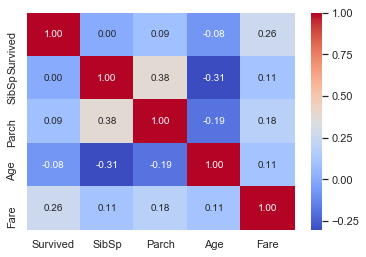

In [10]:
g = sns.heatmap(train[["Survived", 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap ='coolwarm')

- `Fare` 와 `Survived` 상관관계만 양의 값 

#### SibSp

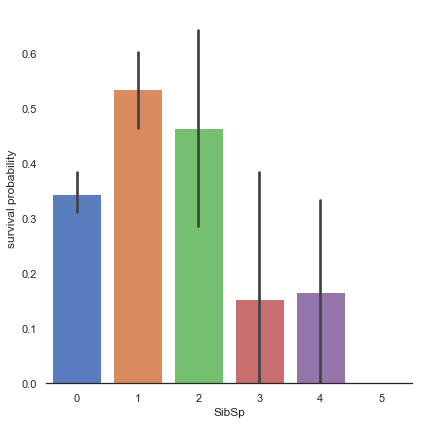

In [11]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind ='bar', size=6,
                  palette='muted')

g.despine(left=True)
g = g.set_ylabels('survival probability')

<br>

#### Parch

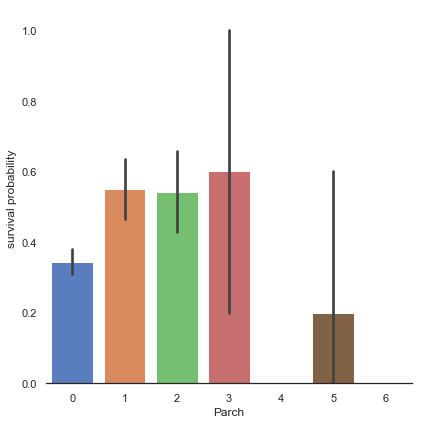

In [12]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6,
                  palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

<br>

#### Age

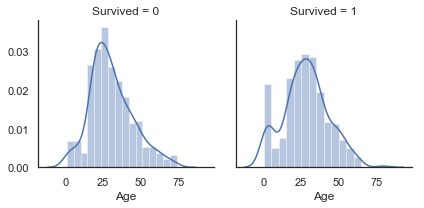

In [13]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

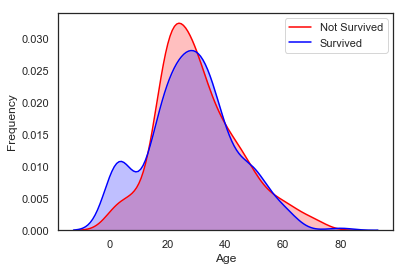

In [14]:
# #xplore Age distribution

g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color = 'Red', shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], color = "Blue", shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(["Not Survived", "Survived"])

<br>

#### Fare

In [15]:
# 결측치 확인
dataset["Fare"].isnull().sum()

1

In [16]:
# 결측치 채우기
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

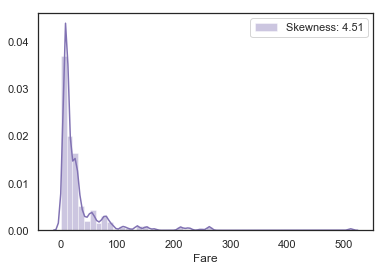

In [17]:
g = sns.distplot(dataset["Fare"], color = 'm', label = 'Skewness: %.2f'%(dataset["Fare"].skew()))
g= g.legend(loc='best')

- Fare distribution is very skewed. This can lead to overweight very high values in the model, even if it is scaled

In [18]:
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i >0 else 0)

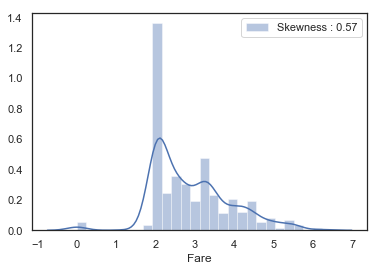

In [19]:
g = sns.distplot(dataset["Fare"], color = 'b', label='Skewness : %.2f'%(dataset["Fare"].skew()))
g=g.legend(loc='best')

<br>

### 2.2 Categorical Values

#### Sex

Text(0, 0.5, 'Survival Probability')

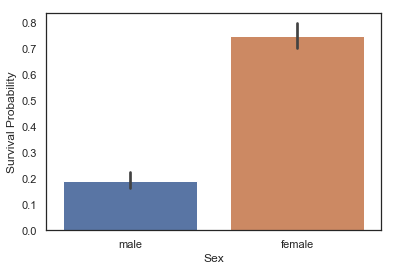

In [20]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g.set_ylabel('Survival Probability')

In [21]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


<br>

#### Pclass

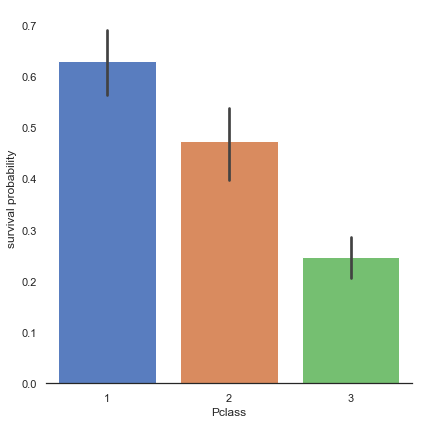

In [22]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')

g.despine(left=True)
g.set_ylabels('survival probability')

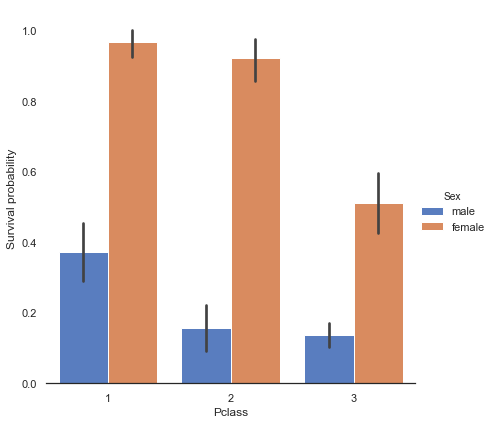

In [23]:
g = sns.factorplot(x ='Pclass', y='Survived', hue = 'Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)

g.set_ylabels('Survival probability')

<br>

#### Embarked

In [24]:
dataset["Embarked"].isnull().sum()

2

In [25]:
dataset.Embarked.value_counts(ascending=False)

# 가장 많은 빈도를 차지하는 결과값이 'S' 이므로 결측치는 'S'로 채우기

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [26]:
dataset["Embarked"] = dataset["Embarked"].fillna('S')

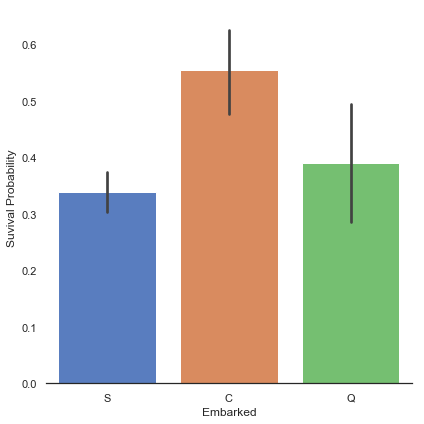

In [27]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind = 'bar',
                  palette='muted')
g.despine(left = True)
g.set_ylabels('Suvival Probability')

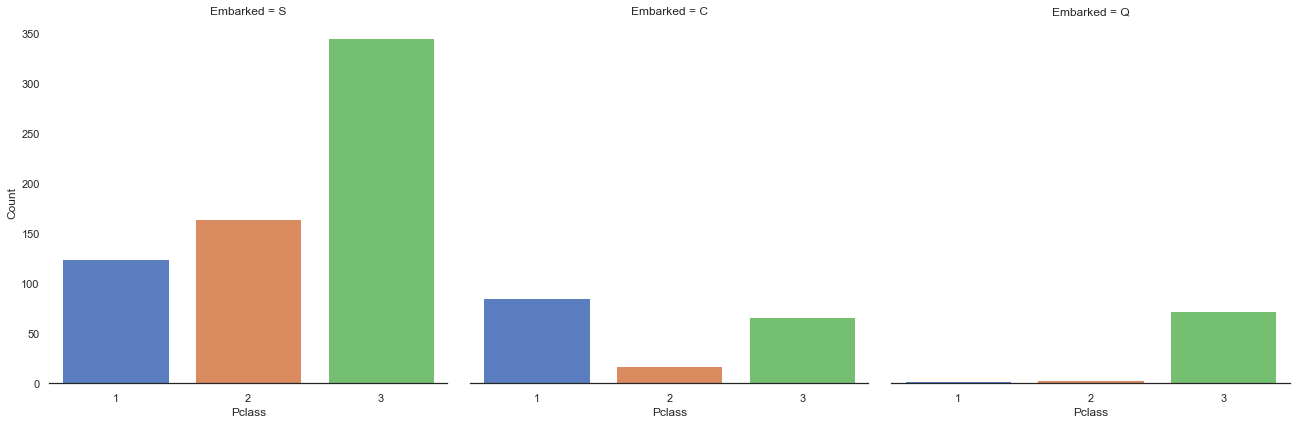

In [28]:
g = sns.factorplot("Pclass", col='Embarked', data=train, size=6, kind='count', palette='muted')

g.despine(left=True)
g.set_ylabels('Count')

<br>


### 3. Filling missing values

#### 3.1 Age

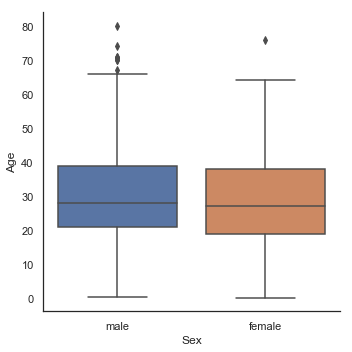

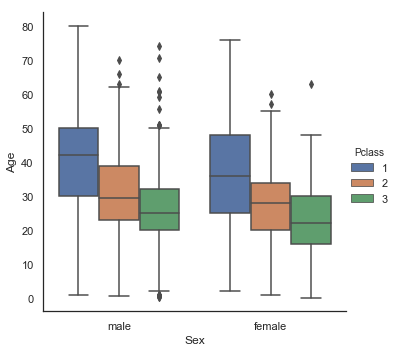

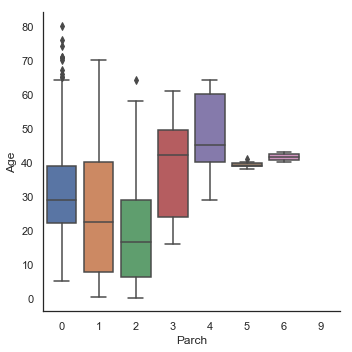

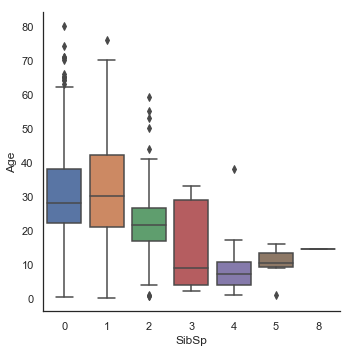

In [29]:
sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')

sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')

sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')

sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [30]:
# Convert Sex into categorical value 0 for male and 1 for female

dataset["Sex"] = dataset["Sex"].map({'male':0, 'female':1})

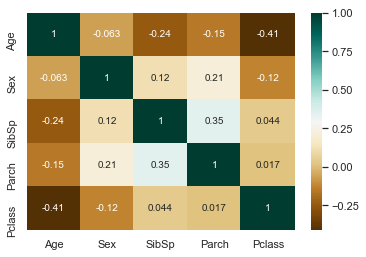

In [31]:
sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap='BrBG', annot=True)

In [32]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"]) 
                               & (dataset["Parch"] == dataset.iloc[i]["Parch"]) 
                               & (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

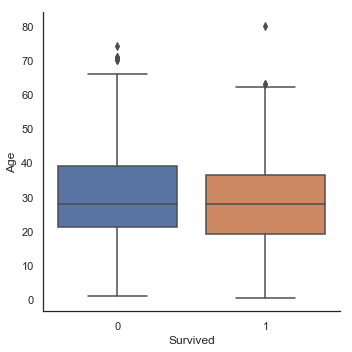

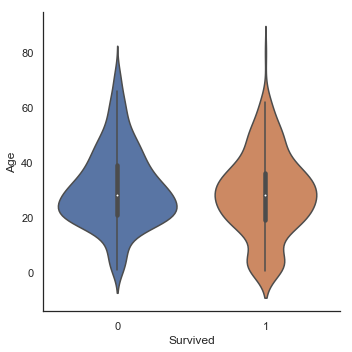

In [33]:
sns.factorplot(x='Survived', y ='Age', data=train, kind= 'box')
sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

<br>

### 4. Feature engineering

#### 4.1 Name/Title

In [34]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

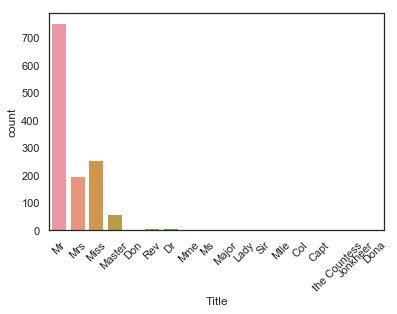

In [36]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [37]:
dataset["Title"] = dataset["Title"].replace(["Lady", "the Countess", 'Countess', 'Capt',
                                            'Col', "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")

dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms":1, "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

dataset["Title"] = dataset["Title"].astype(int)

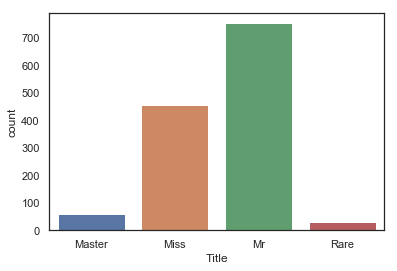

In [38]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss", "Mr", "Rare"])

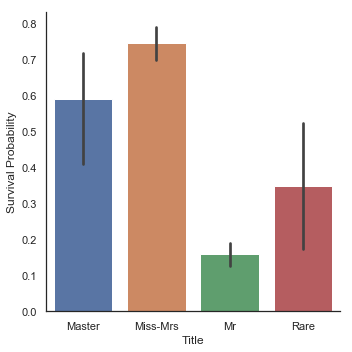

In [39]:
g = sns.factorplot(x='Title', y="Survived", data=dataset, kind='bar')
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels('Survival Probability')

In [40]:
# 필요없는 변수 지우기

dataset.drop(labels = ["Name"], axis=1, inplace=True)

<br>

#### 4.2 Family Size

In [41]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] +1

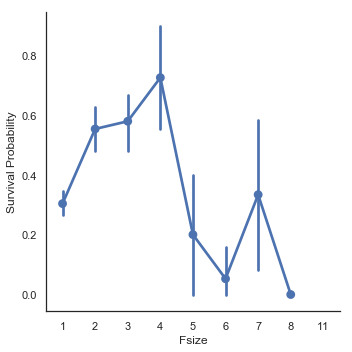

In [42]:
g=sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

In [43]:
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s ==1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s ==2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

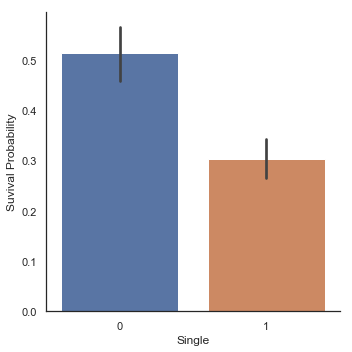

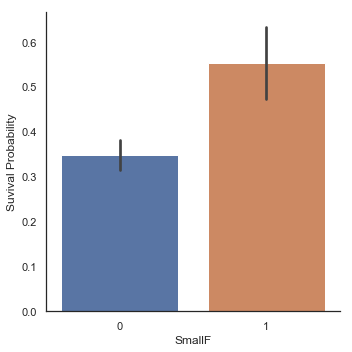

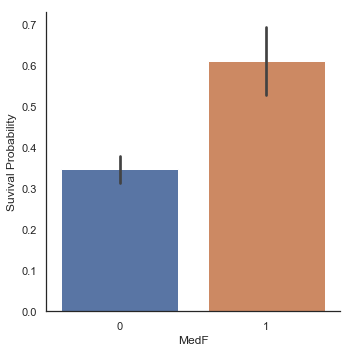

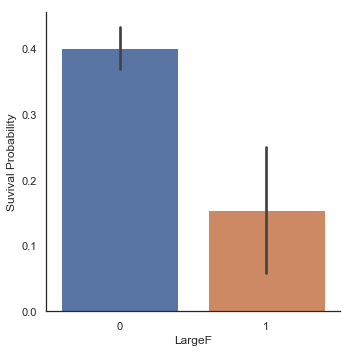

In [44]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Suvival Probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Suvival Probability')

g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Suvival Probability')

g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Suvival Probability')

In [45]:
dataset[['Title', "Embarked"]].head()

,Title,Embarked
0,2,S
1,1,C
2,1,S
3,1,S
4,2,S


In [46]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix ='Em')

# get_dummies : Convert categorical variable into dummy/indicator variables

In [47]:
dataset.filter(like=('Title'), axis=1).head()

,Title_0,Title_1,Title_2,Title_3
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [48]:
dataset.filter(like=('Em'), axis=1).head()

,Em_C,Em_Q,Em_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


<br>

#### 4.3 Cabin

In [49]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset["Cabin"].isnull().sum()

1007

In [52]:
# 결측치 없는 것들 제외하고 보기 
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
# Replace the Cabin number by the type of cabin 'X' if not 
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"]])
# i[0] : 첫번째 글자로 저장 notnull 이면

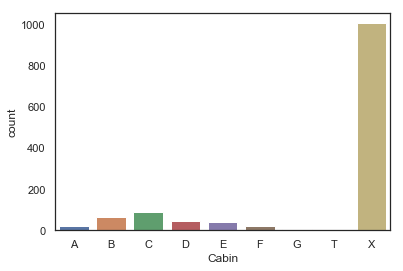

In [54]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X']) 

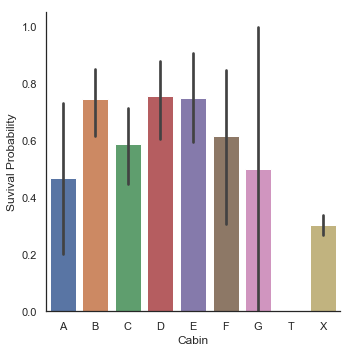

In [55]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G','T','X'])
g.set_ylabels('Suvival Probability')
                                                                             

In [56]:
dataset=pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')
dataset.filter(like='Cabin').head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


<br>

#### 4.4 Ticket

In [57]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() : # 숫자가 아니면
        Ticket.append(i.replace('.', '').replace('/','').strip().split(' ')[0])
    else: # 숫자이면
        Ticket.append('X')
dataset["Ticket"] = Ticket
dataset['Ticket'].head()        

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset=pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [60]:
dataset['Pclass'] = dataset["Pclass"].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [61]:
# Drop useless variables

dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [62]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


<br>

### EDA : Practice 01 과 Practice 02 와 다른 점
- `Age` : 범주화 하지 않음
- `Fare` : 범주화 하지 않음. cf. Practice 02는 `Fare` -> `Fare_range` -> `Fare_cat`
- dummies 사용

<br>

## 5. Modeling


In [63]:

# 자동으로 train 과 test set을 나누지 않고, 직접 지정

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis= 1, inplace=True)

In [64]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train=train.drop(labels=['Survived'], axis=1)

<br>

#### 5.1 Modeling
- Cross validate models
    - SVC
    - Decision Tree
    - AdaBoost
    - Extra Trees
    - Gradient Boosting
    - Multiple layer perceptron(neural network)
    - KNN
    - Logistic regression
    - Linear Discriminang Analysis

In [65]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

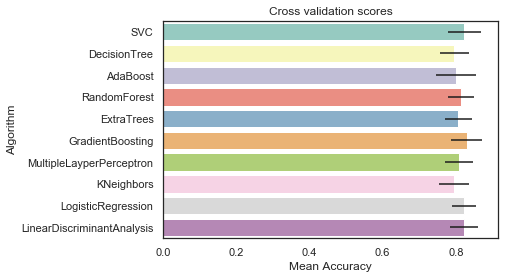

In [66]:
# Modeling step Test diffrents algorithms

random_state = 2
classifiers= []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                     random_state=random_state, learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

classifiers.append(MLPClassifier(random_state=random_state)) # 이거 NN 신기한 것
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())


cv_results=[]

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means =[]
cv_std =[]

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std, 'Algorithm': ["SVC", "DecisionTree", 'AdaBoost',
                                                                                       'RandomForest', 'ExtraTrees', 'GradientBoosting','MultipleLayperPerceptron',
                                                                                       'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette = 'Set3', orient='h', **{'xerr':cv_std}) # 이거 새롭다
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

In [67]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.822944,0.045155,SVC
1,0.795774,0.039714,DecisionTree
2,0.801456,0.054777,AdaBoost
3,0.814977,0.035252,RandomForest
4,0.807035,0.036652,ExtraTrees
5,0.829724,0.041959,GradientBoosting
6,0.808172,0.038518,MultipleLayperPerceptron
7,0.795710,0.040837,KNeighbors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


<br>

#### Hyper-parameter tunning for best models

In [68]:
### META MODELING WITH ADABOOST, RF, EXTRATREES, and GRADIENTBOOSTING

# Adaboost

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid={"base_estimator__criterion": ['gini', 'entropy'],
               'base_estimator__splitter':['best', 'random'],
               'algorithm': ['SAMME', 'SAMME.R'],
               'n_estimators':[1,2],
               'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best=gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.6s finished


In [69]:
ada_best

# learning_rate : 0.2, n_estimators = 2, criterion ='entropy'

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)

In [70]:
gsadaDTC.best_score_

0.8240635641316686

In [71]:
#ExtraTrees

ExtC = ExtraTreesClassifier()


## Search Grid for optimal parameters
ex_param_grid = {'max_depth':[None], 'max_features':[1, 3, 10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10], 'bootstrap':[False], 'n_estimators':[100,300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=kfold, scoring = 'accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best Score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   35.2s finished


0.8308740068104427

In [72]:
# RFC Parameters tunning

RFC = RandomForestClassifier()

## Search Grid for optimal parameters
rf_param_grid = {'max_depth':[None], 'max_features':[1, 3, 10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10], 'bootstrap':[False], 'n_estimators':[100,300],
                'criterion':['gini']}
gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring = 'accuracy', n_jobs=4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best Score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   36.6s finished


0.8331441543700341

In [73]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss':['deviance'], 'max_features':[0.3, 0.1],
                'max_depth':[4,8],
                 'learning_rate':[0.1, 0.05, 0.01],
                'min_samples_leaf':[100, 150], 'n_estimators':[100,200,300]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring = 'accuracy',n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best Score
gsGBC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   23.8s finished


0.8308740068104427

In [74]:
# SVC classifier

SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'], 'gamma':[0.001, 0.01, 0.1, 1],
                 'C':[1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring = 'accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   28.5s finished


0.8331441543700341

<br>

#### Plot learning curves

- Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy

In [75]:
def plt_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt

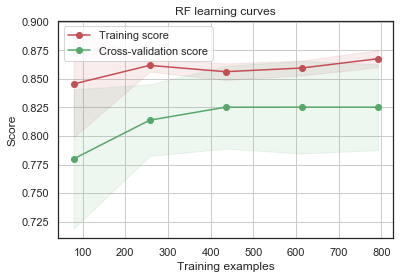

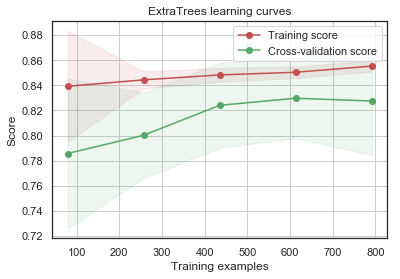

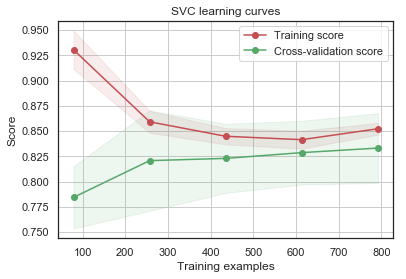

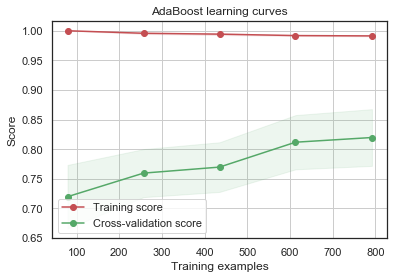

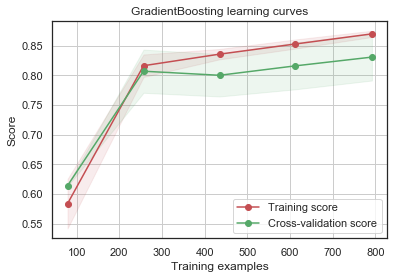

In [76]:
g = plt_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)

g = plt_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)

g = plt_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)

g = plt_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)

g = plt_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

- GradientBoosting 과 Adaboost는 과적합
- SVC와 ExtraTrees classifiers 가 괜찮음

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

## 이거 해석 ?????????????

<br>


#### Feature importance of tree based classifiers

In [77]:
ada_best.feature_importances_

array([0.18021379, 0.22216499, 0.00547777, 0.15400408, 0.01561225,
       0.02026274, 0.01321328, 0.00080988, 0.00365953, 0.03224953,
       0.00594731, 0.00682391, 0.12589197, 0.02114639, 0.01124282,
       0.0045234 , 0.02209245, 0.00199914, 0.00307158, 0.01476715,
       0.01052036, 0.00495692, 0.00121641, 0.        , 0.        ,
       0.00864901, 0.        , 0.00197369, 0.00587874, 0.        ,
       0.        , 0.        , 0.00347533, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00252793, 0.        ,
       0.00257573, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00172393, 0.        ,
       0.        , 0.        , 0.00469288, 0.        , 0.00203799,
       0.        , 0.00635162, 0.        , 0.        , 0.00886066,
       0.        , 0.        , 0.01497219, 0.        , 0.00605277,
       0.0483599 ])

In [78]:
np.argsort(ada_best.feature_importances_)

array([30, 31, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50,
       51, 53, 55, 57, 58, 29, 26, 60, 23, 63, 61, 24,  7, 22, 48, 27, 17,
       54, 38, 40, 18, 32,  8, 15, 52, 21,  2, 28, 10, 64, 56, 11, 25, 59,
       20, 14,  6, 19, 62,  4,  5, 13, 16,  9, 65, 12,  3,  0,  1],
      dtype=int64)

In [81]:
np.argsort(ada_best.feature_importances_)[::-1]

array([ 1,  0,  3, 12, 65,  9, 16, 13,  5,  4, 62, 19,  6, 14, 20, 59, 25,
       11, 56, 64, 10, 28,  2, 21, 52, 15,  8, 32, 18, 40, 38, 54, 17, 27,
       48, 22,  7, 24, 61, 63, 23, 60, 26, 29, 58, 57, 55, 53, 51, 50, 49,
       47, 46, 45, 44, 43, 42, 41, 39, 37, 36, 35, 34, 33, 31, 30],
      dtype=int64)

In [83]:
len(np.argsort(ada_best.feature_importances_)[::-1][:40])

40

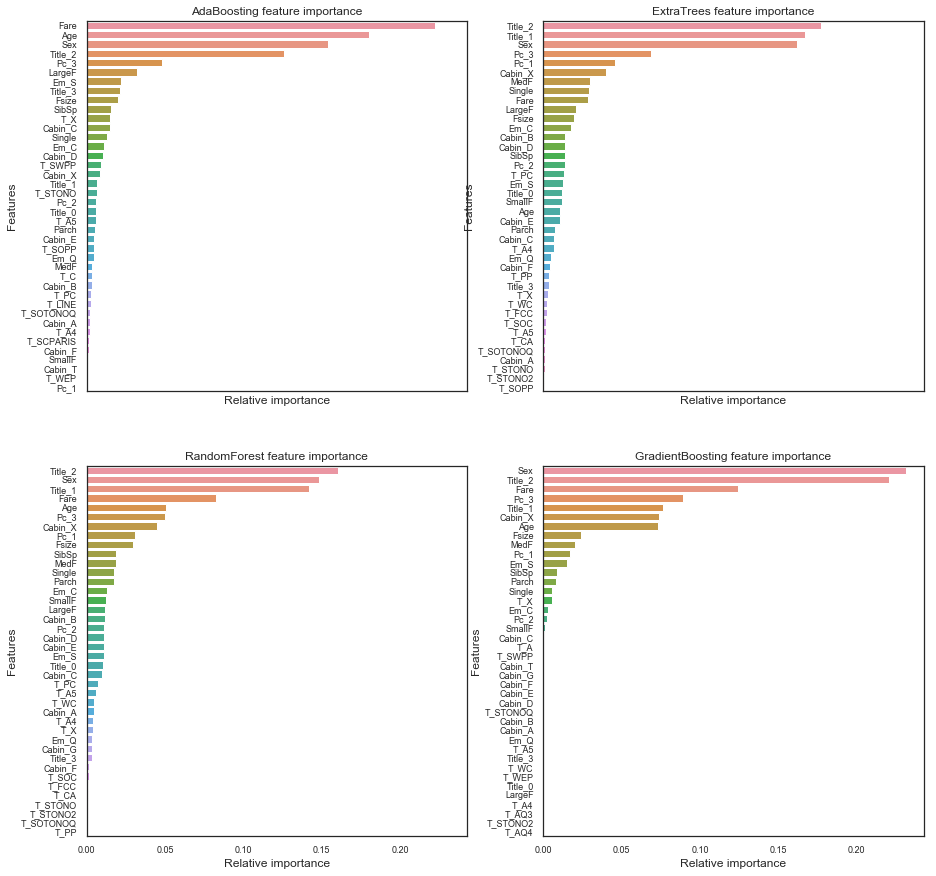

In [182]:
nrows = ncols = 2

f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best),
                    ('GradientBoosting', GBC_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0] #AdaBoostin
        classifier = names_classifiers[nclassifier][1] # ada_best
        indices = np.argsort(classifier.feature_importances_)[::-1][:40] ###
        
        g= sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40],
                      orient='h', ax=ax[row][col])
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

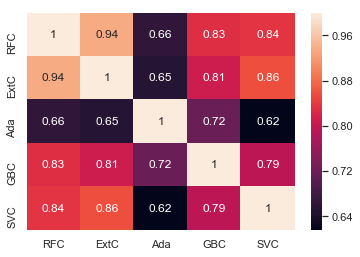

In [183]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC,
                             test_Survived_SVMC], axis=1)

g= sns.heatmap(ensemble_results.corr(), annot=True)
# annot : bool or rectangular dataset, optional # 값 표시할지 말지
#     If True, write the data value in each cell. If an array-like with the
#     same shape as ``data``, then use this to annotate the heatmap instead
#     of the raw data.

<br>

### 5.2 Ensemble modeling

In [184]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best),
                                        ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [185]:
votingC

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weigh...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)

<br>

### 5.3 Prediction

In [186]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv('ensemble_python_voting.csv', index=False)

In [187]:
results_data = pd.read_csv('ensemble_python_voting.csv')
results_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
